In [1]:
import numpy as np
import random
from itertools import permutations

In [ ]:
def generate_modular_division_dataset(p=97, train_fraction=0.5, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    
    equations = []
    
    for x in range(p):
        for y in range(1, p):
            result = (x * pow(y, p-2, p)) % p
            equations.append((x, y, result))
    
    random.shuffle(equations)
    split_idx = int(len(equations) * train_fraction)
    
    train_data = equations[:split_idx]
    val_data = equations[split_idx:]
    
    return train_data, val_data

train_data, val_data = generate_modular_division_dataset(p=97, train_fraction=0.5)
print(f"Train size: {len(train_data)}, Val size: {len(val_data)}")

Train size: 4656, Val size: 4656


In [3]:
def create_vocab(p=97):
    vocab = {
        'op': 0,
        'eq': 1,
    }
    
    for i in range(p):
        vocab[f'num_{i}'] = i + 2
    
    return vocab

def tokenize_equation(equation, vocab):
    a, b, c = equation
    return [
        vocab[f'num_{a}'],
        vocab['op'],
        vocab[f'num_{b}'],
        vocab['eq'],
        vocab[f'num_{c}']
    ]

vocab = create_vocab(p=97)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

import torch

def prepare_data(equations, vocab):
    """Prepare data for training"""
    tokenized = [tokenize_equation(eq, vocab) for eq in equations]
    
    X = torch.tensor([seq[:-1] for seq in tokenized])
    y = torch.tensor([seq[-1] for seq in tokenized])
    
    return X, y

X_train, y_train = prepare_data(train_data, vocab)
X_val, y_val = prepare_data(val_data, vocab)

Vocabulary size: 99


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, dropout=0.0):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Embedding(5, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.output_layer = nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        positions = torch.arange(x.size(1), device=x.device).unsqueeze(0)

        x = self.embedding(x) + self.pos_encoding(positions)
        
        seq_len = x.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)

        x = self.transformer(x, mask=mask)
        
        x = x[:, -1, :]
        logits = self.output_layer(x)
        
        return logits

model = SimpleTransformer(vocab_size=vocab_size, d_model=128, nhead=4, num_layers=2)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 422,627


In [5]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = min(512, len(train_dataset) // 2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-3,
    betas=(0.9, 0.98)
)

criterion = nn.CrossEntropyLoss()

In [6]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
    
    return total_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    
    return total_loss / len(loader), 100 * correct / total

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_steps = 250000
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'steps': []
}

step = 0
log_interval = 50

print("Training...")
pbar = tqdm(total=num_steps)

while step < num_steps:
    for X_batch, y_batch in train_loader:
        if step >= num_steps:
            break
            
        model.train()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        step += 1
        pbar.update(1)
        
        if step % log_interval == 0:
            train_loss, train_acc = evaluate(model, train_loader, criterion, device)
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            
            history['steps'].append(step)
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            pbar.set_postfix({
                'train_acc': f'{train_acc:.1f}%',
                'val_acc': f'{val_acc:.1f}%'
            })

pbar.close()
print("Training complete!")

Training...


100%|██████████| 250000/250000 [1:23:06<00:00, 50.13it/s, train_acc=100.0%, val_acc=99.7%] 

Training complete!


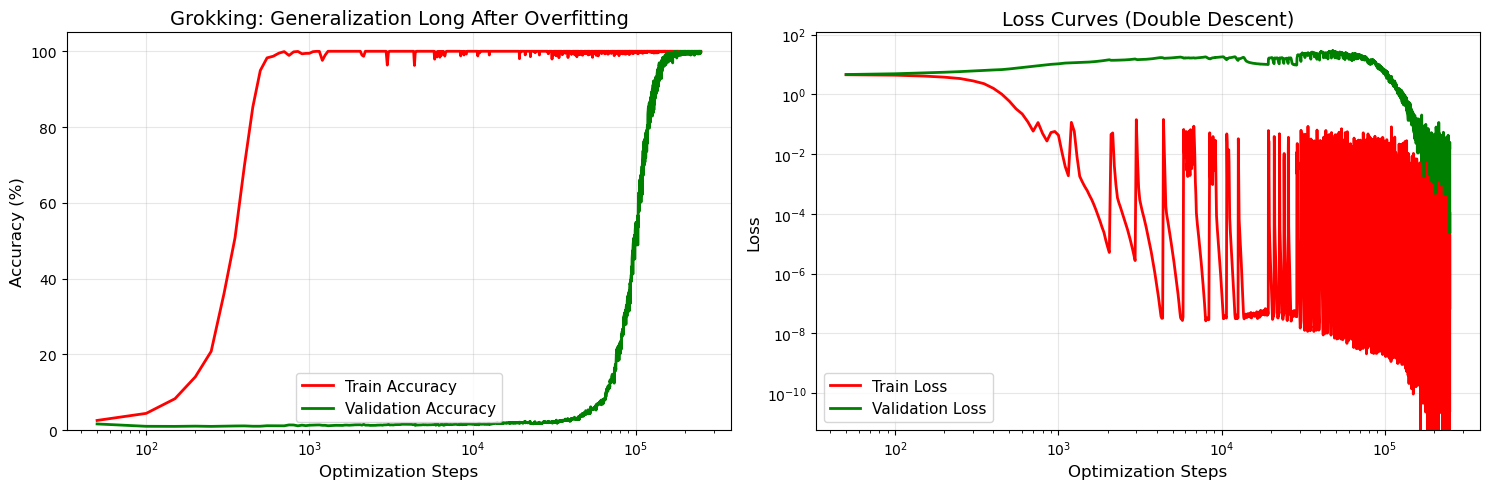


Final Results:
Train Accuracy: 100.00%
Val Accuracy: 99.72%


In [7]:
def plot_grokking(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['steps'], history['train_acc'], 'r-', label='Train Accuracy', linewidth=2)
    ax1.plot(history['steps'], history['val_acc'], 'g-', label='Validation Accuracy', linewidth=2)
    ax1.set_xlabel('Optimization Steps', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_xscale('log')
    ax1.set_title('Grokking: Generalization Long After Overfitting', fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 105])
    
    ax2.plot(history['steps'], history['train_loss'], 'r-', label='Train Loss', linewidth=2)
    ax2.plot(history['steps'], history['val_loss'], 'g-', label='Validation Loss', linewidth=2)
    ax2.set_xlabel('Optimization Steps', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_title('Loss Curves (Double Descent)', fontsize=14)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('grokking_result_optimized.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nFinal Results:")
    print(f"Train Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"Val Accuracy: {history['val_acc'][-1]:.2f}%")

plot_grokking(history)